# 1. Setup

## 1-1. Library Setup

In [ ]:
import os
import numpy as np
from keras.utils import np_utils
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
import tqdm

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3515258913891993261
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6375921636287246543
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [ ]:
!nvidia-smi

Tue Dec 14 02:35:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    32W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## 1-2. parameter setup

In [ ]:
image_size = 128
image_channels = 3
batch_size = 64
num_epochs = 100
class_num = 5
imagenet_patience_num = 30

#base_path = ''
base_path = 'gdrive/My Drive/Research_5_2_1/'

path_data = base_path + 'data_numpy/'
path_model_result = base_path + 'model_result/4 - SimCLR + DANN_result - 1/'
model_path = path_model_result + 'model_'

basemodel_load = tf.keras.models.load_model( 'gdrive/My Drive/Research_5_2_1/model_result/3 - SimCLR_result/pretraining_model_encoder.h5' )

In [ ]:
def createDirectory(name): 
    try: 
        if not os.path.exists(name): 
            os.makedirs(name) 
    except OSError: 
        print("Error: Failed to create the directory.")  
        
createDirectory(path_model_result)

# 2. Data Load and Data Setting

## 2-1. Data Load

In [ ]:
combined_train_imgs = np.load(path_data + 'combined_train_imgs.npy')
combined_train_labels = np.load(path_data + 'combined_train_labels.npy')
combined_train_domain = np.load(path_data + 'combined_train_domain.npy')

combined_Valid_imgs = np.load(path_data + 'combined_Valid_imgs.npy')
combined_Valid_labels = np.load(path_data + 'combined_Valid_labels.npy')
combined_Valid_domain = np.load(path_data + 'combined_Valid_domain.npy')

combined_test_imgs = np.load(path_data + 'combined_test_imgs.npy')
combined_test_labels = np.load(path_data + 'combined_test_labels.npy')
combined_test_domain = np.load(path_data + 'combined_test_domain.npy')

In [ ]:
sample_weights_class_label = np.load(path_data + 'sample_weights_class_label.npy')
sample_weights_domain_label = np.load(path_data + 'sample_weights_domain_label.npy')

In [ ]:
print(combined_train_imgs.shape)
print(combined_train_labels.shape)
print(combined_train_domain.shape)
print()
print(combined_Valid_imgs.shape)
print(combined_Valid_labels.shape)
print(combined_Valid_domain.shape)
print()
print(sample_weights_class_label.shape)
print(sample_weights_domain_label.shape)

(4308, 128, 128, 3)
(4308, 5)
(4308, 2)

(1436, 128, 128, 3)
(1436, 5)
(1436, 2)

(4308,)
(4308,)


In [ ]:
xValid_S = np.load(path_data + 'xValid_S.npy')
yValid_S = np.load(path_data + 'yValid_S.npy')

xValid_T = np.load(path_data + 'xValid_T.npy')
yValid_T = np.load(path_data + 'yValid_T.npy')

Valid_S_domain = np.load(path_data + 'Valid_S_domain.npy')
Valid_T_domain = np.load(path_data + 'Valid_T_domain.npy')

xValid_S = xValid_S.astype('float32')/255
yValid_S = np_utils.to_categorical(yValid_S, class_num)

xValid_T = xValid_T.astype('float32')/255
yValid_T = np_utils.to_categorical(yValid_T, class_num)

In [ ]:
print(xValid_S.shape, yValid_S.shape)
print(xValid_T.shape, yValid_T.shape)
print()
print(Valid_S_domain.shape)
print(Valid_T_domain.shape)

(678, 128, 128, 3) (678, 5)
(758, 128, 128, 3) (758, 5)

(678, 2)
(758, 2)


In [ ]:
xTest_S = np.load(path_data + 'xTest_S.npy')
yTest_S = np.load(path_data + 'yTest_S.npy')

xTest_T = np.load(path_data + 'xTest_T.npy')
yTest_T = np.load(path_data + 'yTest_T.npy')

test_S_domain = np.load(path_data + 'test_S_domain.npy')
test_T_domain = np.load(path_data + 'test_T_domain.npy')

xTest_S = xTest_S.astype('float32')/255
yTest_S = np_utils.to_categorical(yTest_S, class_num)

xTest_T = xTest_T.astype('float32')/255
yTest_T = np_utils.to_categorical(yTest_T, class_num)

In [ ]:
print(xTest_S.shape, yTest_S.shape)
print(xTest_T.shape, yTest_T.shape)
print()
print(test_S_domain.shape)
print(test_T_domain.shape)

(678, 128, 128, 3) (678, 5)
(758, 128, 128, 3) (758, 5)

(678, 2)
(758, 2)


# 3. DANN Network

## 3-1. DANN Setting


In [ ]:
@tf.custom_gradient
def GradientReversalOperator(x):
    def grad(dy):
        return -1 * dy
    return x, grad

class GradientReversalLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(GradientReversalLayer, self).__init__()
    def call(self, inputs):
        return GradientReversalOperator(inputs)

def classifier(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(64, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out) 
    return classifier_output

def discriminator(inp):
    out = Dense(32, activation="relu")(inp)
    discriminator_output = Dense(2, activation="softmax", name="discriminator_output")(out)
    return discriminator_output

def dann():    
    inp = Input(shape=(image_size, image_size, image_channels))
    feature_output = basemodel_load(inp)
    classifier_output = classifier(feature_output)
    grl_layer = GradientReversalLayer()(feature_output)
    discriminator_output = discriminator(grl_layer)
    model = tf.keras.models.Model(inputs=inp, outputs=[discriminator_output,classifier_output])
    return model

## 3-2. Model Training

In [ ]:
model = dann()
#print(S_dann_model.summary())

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
model.compile(optimizer='adam', 
              loss={'discriminator_output': 'binary_crossentropy',
                    'classifier_output': 'categorical_crossentropy'},
              metrics = ['accuracy'])


ES = EarlyStopping(monitor='val_classifier_output_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)
MC = ModelCheckpoint( path_model_result + 'model_{epoch}.h5', monitor='val_classifier_output_accuracy', mode='max', verbose=1, save_best_only=False, save_freq='epoch')


dann_model = model.fit(combined_train_imgs,[combined_train_domain,combined_train_labels], 
                        sample_weight=[sample_weights_domain_label, sample_weights_class_label],
                        epochs=num_epochs, batch_size=batch_size, validation_data=(combined_Valid_imgs,[combined_Valid_domain,combined_Valid_labels]), callbacks=[ES, MC])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(dann_model.history["val_classifier_output_accuracy"]) * 100))

Epoch 1/100
68/68 [==============================] - ETA: 0s - loss: 1.2709 - discriminator_output_loss: 0.9971 - classifier_output_loss: 0.2738 - discriminator_output_accuracy: 0.4225 - classifier_output_accuracy: 0.5754
Epoch 00001: saving model to gdrive/My Drive/Research_3_1_2/model_result/4 - SimCLR + DANN_model_result - 1/model_1.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


68/68 [==============================] - 33s 294ms/step - loss: 1.2709 - discriminator_output_loss: 0.9971 - classifier_output_loss: 0.2738 - discriminator_output_accuracy: 0.4225 - classifier_output_accuracy: 0.5754 - val_loss: 19.8409 - val_discriminator_output_loss: 2.5649 - val_classifier_output_loss: 17.2760 - val_discriminator_output_accuracy: 0.6825 - val_classifier_output_accuracy: 0.5794
Epoch 2/100
68/68 [==============================] - ETA: 0s - loss: 0.8843 - discriminator_output_loss: 0.7620 - classifier_output_loss: 0.1222 - discriminator_output_accuracy: 0.5246 - classifier_output_accuracy: 0.6026
Epoch 00002: saving model to gdrive/My Drive/Research_3_1_2/model_result/4 - SimCLR + DANN_model_result - 1/model_2.h5
68/68 [==============================] - 18s 268ms/step - loss: 0.8843 - discriminator_output_loss: 0.7620 - classifier_output_loss: 0.1222 - discriminator_output_accuracy: 0.5246 - classifier_output_accuracy: 0.6026 - val_loss: 19.7425 - val_discriminator_ou

In [ ]:
dann_model_df = pd.DataFrame(dann_model.history)
dann_model_df.to_csv( path_model_result + 'history_df.csv' )
dann_model_df

,loss,discriminator_output_loss,classifier_output_loss,discriminator_output_accuracy,classifier_output_accuracy,val_loss,val_discriminator_output_loss,val_classifier_output_loss,val_discriminator_output_accuracy,val_classifier_output_accuracy
0,1.270881,0.997097,0.273784,0.422470,0.575441,19.840893,2.564940,17.275951,0.682451,0.579387
1,0.884252,0.762017,0.122236,0.524605,0.602600,19.742531,6.059390,13.683140,0.459610,0.493733
2,0.816514,0.704474,0.112040,0.536444,0.600511,13.519028,1.045811,12.473215,0.457521,0.332869
3,0.768335,0.692800,0.075535,0.527159,0.610724,9.964033,0.695376,9.268656,0.474930,0.550139
4,0.791259,0.690494,0.100765,0.527391,0.594940,2.727221,0.688575,2.038645,0.558496,0.571031
5,0.733439,0.691504,0.041934,0.564067,0.617456,2.603311,0.679185,1.924126,0.623955,0.625348
6,0.732802,0.701097,0.031704,0.516481,0.605617,12.491207,0.969520,11.521688,0.384401,0.587047
7,0.788845,0.691995,0.096850,0.523213,0.614670,75.966415,0.850670,75.115738,0.344708,0.260446
8,0.792323,0.688215,0.104108,0.568942,0.612581,3.922818,0.668095,3.254723,0.674791,0.565460
9,0.732630,0.694269,0.038361,0.509517,0.620706,4.424999,0.693119,3.731881,0.452646,0.616992


Minimum validation loss: 2.6033108234405518
Maximum val_classifier_output_accuracy: 0.6594707369804382


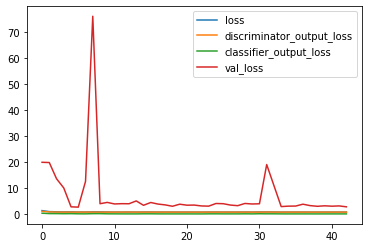

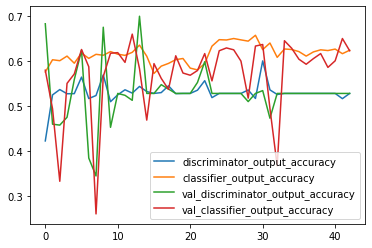

In [ ]:
dann_model_df.loc[:, ['loss', 'discriminator_output_loss', 'classifier_output_loss', 'val_loss']].plot();
plt.savefig(path_model_result + 'loss,val_loss.png')
dann_model_df.loc[:, ['discriminator_output_accuracy', 'classifier_output_accuracy', 'val_discriminator_output_accuracy', 'val_classifier_output_accuracy']].plot();
plt.savefig(path_model_result + 'accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(dann_model_df['val_loss'].min()))
print("Maximum val_classifier_output_accuracy: {}".format(dann_model_df['val_classifier_output_accuracy'].max()))

In [ ]:
print("Evaluate on test data")
source_acc = model.evaluate( xTest_S,[test_S_domain, yTest_S] )
print('dann_source_acc :',round(source_acc[-1]*100,5),'%')

Evaluate on test data
22/22 [==============================] - 1s 50ms/step - loss: 1.4834 - discriminator_output_loss: 1.3191 - classifier_output_loss: 0.1644 - discriminator_output_accuracy: 0.1858 - classifier_output_accuracy: 0.9705
dann_source_acc : 97.05015 %


In [ ]:
print("Evaluate on test data")
target_acc = model.evaluate( xTest_T,[test_T_domain, yTest_T] )
print('dann_target_acc :',round(target_acc[-1]*100,5),'%')

Evaluate on test data
24/24 [==============================] - 1s 36ms/step - loss: 6.7082 - discriminator_output_loss: 0.6597 - classifier_output_loss: 6.0485 - discriminator_output_accuracy: 0.8034 - classifier_output_accuracy: 0.3430
dann_target_acc : 34.30079 %


## 3-3. Load_weights and epoch_train,epoch_evaluate

In [ ]:
def epoch_train():

    epoch_num = dann_model_df.shape[0]
    print(epoch_num)
    epoch_num = epoch_num+1

    epoch_source_acc_evaluate = []
    epoch_target_acc_evaluate = []

    for i in range(1, epoch_num):
        temp = i
        temp = str(temp)
        print(path_model_result + 'model_' + temp + '.h5')
        temp1=str(path_model_result + 'model_' + temp + '.h5')
        print(temp1)

        model.load_weights(temp1)
        source_acc = model.evaluate( xValid_S,[Valid_S_domain, yValid_S] )
        target_acc = model.evaluate( xValid_T,[Valid_T_domain, yValid_T] )
        print('dann_source_acc :',round(source_acc[-1]*100,5),'%')
        print('dann_target_acc :',round(target_acc[-1]*100,5),'%')

        epoch_source_acc_evaluate.append(source_acc)
        epoch_target_acc_evaluate.append(target_acc)

    epoch_result_temp = list(map(list.__add__, epoch_source_acc_evaluate, epoch_target_acc_evaluate))
    epoch_train_df = pd.DataFrame(epoch_result_temp, columns=['S-loss', 'S-discriminator_output_loss', 'S-classifier_output_loss', 'S-discriminator_output_accuracy', 'S-classifier_output_accuracy', 'T-loss', 'T-discriminator_output_loss', 'T-classifier_output_loss', 'T-discriminator_output_accuracy', 'T-classifier_output_accuracy'])
    epoch_train_df.to_csv( path_model_result + 'epoch_train_df_df.csv' )
    epoch_train_df

    return ()

In [ ]:
epoch_train()

43
gdrive/My Drive/Research_3_1_2/model_result/4 - SimCLR + DANN_model_result - 1/model_1.h5
gdrive/My Drive/Research_3_1_2/model_result/4 - SimCLR + DANN_model_result - 1/model_1.h5
24/24 [==============================] - 1s 30ms/step - loss: 35.8954 - discriminator_output_loss: 4.5959 - classifier_output_loss: 31.2994 - discriminator_output_accuracy: 0.3997 - classifier_output_accuracy: 0.3602
dann_source_acc : 82.44838 %
dann_target_acc : 36.01583 %
gdrive/My Drive/Research_3_1_2/model_result/4 - SimCLR + DANN_model_result - 1/model_2.h5
gdrive/My Drive/Research_3_1_2/model_result/4 - SimCLR + DANN_model_result - 1/model_2.h5
24/24 [==============================] - 1s 30ms/step - loss: 12.5619 - discriminator_output_loss: 0.7171 - classifier_output_loss: 11.8448 - discriminator_output_accuracy: 0.7309 - classifier_output_accuracy: 0.2916
dann_source_acc : 71.9764 %
dann_target_acc : 29.15567 %
gdrive/My Drive/Research_3_1_2/model_result/4 - SimCLR + DANN_model_result - 1/model_3.h

()

In [ ]:
def epoch_evaluate():

    epoch_num = dann_model_df.shape[0]
    print(epoch_num)
    epoch_num = epoch_num+1

    epoch_source_acc_evaluate = []
    epoch_target_acc_evaluate = []

    for i in range(1, epoch_num):
        temp = i
        temp = str(temp)
        print(path_model_result + 'model_' + temp + '.h5')
        temp1=str(path_model_result + 'model_' + temp + '.h5')
        print(temp1)

        model.load_weights(temp1)
        source_acc = model.evaluate( xTest_S,[test_S_domain, yTest_S] )
        target_acc = model.evaluate( xTest_T,[test_T_domain, yTest_T] )
        print('dann_source_acc :',round(source_acc[-1]*100,5),'%')
        print('dann_target_acc :',round(target_acc[-1]*100,5),'%')

        epoch_source_acc_evaluate.append(source_acc)
        epoch_target_acc_evaluate.append(target_acc)

    epoch_result_temp = list(map(list.__add__, epoch_source_acc_evaluate, epoch_target_acc_evaluate))
    epoch_evaluate_df = pd.DataFrame(epoch_result_temp, columns=['S-loss', 'S-discriminator_output_loss', 'S-classifier_output_loss', 'S-discriminator_output_accuracy', 'S-classifier_output_accuracy', 'T-loss', 'T-discriminator_output_loss', 'T-classifier_output_loss', 'T-discriminator_output_accuracy', 'T-classifier_output_accuracy'])
    epoch_evaluate_df.to_csv( path_model_result + 'epoch_evaluate_df.csv' )
    epoch_evaluate_df

    return ()

In [ ]:
epoch_evaluate()

43
gdrive/My Drive/Research_3_1_2/model_result/4 - SimCLR + DANN_model_result - 1/model_1.h5
gdrive/My Drive/Research_3_1_2/model_result/4 - SimCLR + DANN_model_result - 1/model_1.h5
24/24 [==============================] - 1s 30ms/step - loss: 27.0215 - discriminator_output_loss: 4.1050 - classifier_output_loss: 22.9165 - discriminator_output_accuracy: 0.4393 - classifier_output_accuracy: 0.3562
dann_source_acc : 82.15339 %
dann_target_acc : 35.62005 %
gdrive/My Drive/Research_3_1_2/model_result/4 - SimCLR + DANN_model_result - 1/model_2.h5
gdrive/My Drive/Research_3_1_2/model_result/4 - SimCLR + DANN_model_result - 1/model_2.h5
24/24 [==============================] - 1s 30ms/step - loss: 11.6298 - discriminator_output_loss: 0.7133 - classifier_output_loss: 10.9165 - discriminator_output_accuracy: 0.7111 - classifier_output_accuracy: 0.3259
dann_source_acc : 71.9764 %
dann_target_acc : 32.58575 %
gdrive/My Drive/Research_3_1_2/model_result/4 - SimCLR + DANN_model_result - 1/model_3.h

()

In [ ]:
model.load_weights('gdrive/My Drive/Research_5_2_1/model_result/4 - SimCLR + DANN_result - 1/model_30.h5')
print("Evaluate on test data")
source_acc = model.evaluate( xTest_S,[test_S_domain, yTest_S] )
print('dann_target_acc :',round(source_acc [-1]*100,5),'%')
target_acc = model.evaluate( xTest_T,[test_T_domain, yTest_T] )
print('dann_target_acc :',round(target_acc[-1]*100,5),'%')

Evaluate on test data
22/22 [==============================] - 1s 30ms/step - loss: 1.3802 - discriminator_output_loss: 0.7547 - classifier_output_loss: 0.6254 - discriminator_output_accuracy: 0.0000e+00 - classifier_output_accuracy: 0.9218
dann_target_acc : 92.18289 %
24/24 [==============================] - 1s 31ms/step - loss: 6.0365 - discriminator_output_loss: 0.6347 - classifier_output_loss: 5.4018 - discriminator_output_accuracy: 1.0000 - classifier_output_accuracy: 0.3839
dann_target_acc : 38.3905 %


# 4. Result Report

In [ ]:
print( 'dann_model' + " →→→ Target Test")
print('target_acc :',round(target_acc[-1]*100,5),'%')

dann_model →→→ Target Test
target_acc : 38.3905 %


# 5. Model Save 

In [ ]:
model.save( path_model_result + 'dann_model_last.h5' )

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## 기타 - TSNE 확인

In [ ]:
def plot_embedding1(X, y, d, title=None):
    """Plot an embedding X with the class label y colored by the domain d."""
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    # Plot colors numbers
    plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    for i in tqdm.tqdm(range(X.shape[0])):
        # plot colored number
        if d[i] == 0:
            color = 'green'
        elif d[i] == 1:
            color = 'red'
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=color,
                 fontdict={'weight': 'bold', 'size': 10})
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_embedding2(X, y, d, title=None):
    """Plot an embedding X with the class label y colored by the domain d."""
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    # Plot colors numbers
    plt.figure(figsize=(30,30))
    ax = plt.subplot(111)
    for i in tqdm.tqdm(range(X.shape[0])):
        # plot colored number
        if d[i] == 0:
            color = 'green'
        elif d[i] == 1:
            color = 'red'
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=color,
                 fontdict={'weight': 'bold', 'size': 10})
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()

In [ ]:
TSNE_model_none = dann()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
100%|██████████| 1436/1436 [00:00<00:00, 4478.94it/s]


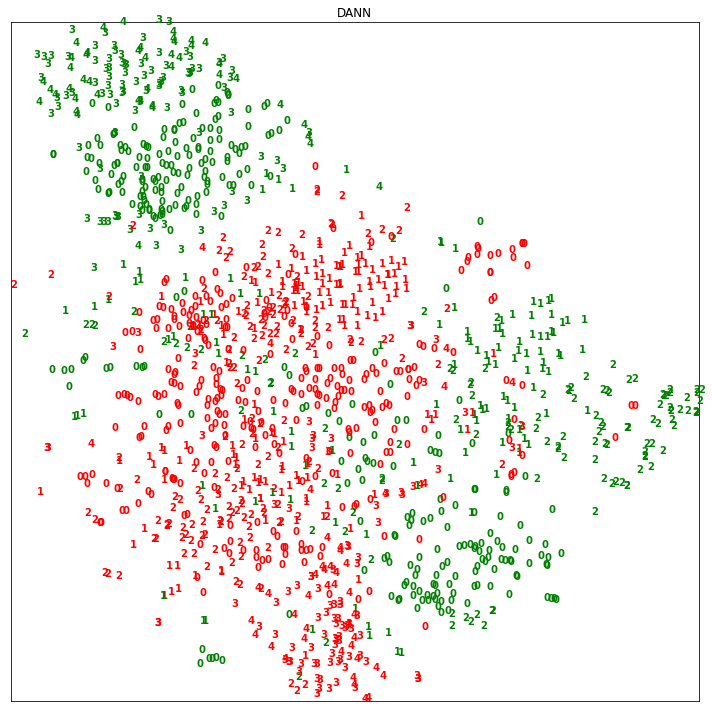

In [ ]:
feature_model = Model(TSNE_model_none.input, TSNE_model_none.get_layer('feature').output)
emb = feature_model.predict(combined_test_imgs)
tsne = TSNE(perplexity=50, n_components=2, init='pca', n_iter=500)
tsne_model = tsne.fit_transform(emb)
plot_embedding1(tsne_model, combined_test_labels.argmax(1)
               ,combined_test_domain.argmax(1),'DANN')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
100%|██████████| 1436/1436 [00:00<00:00, 2282.36it/s]


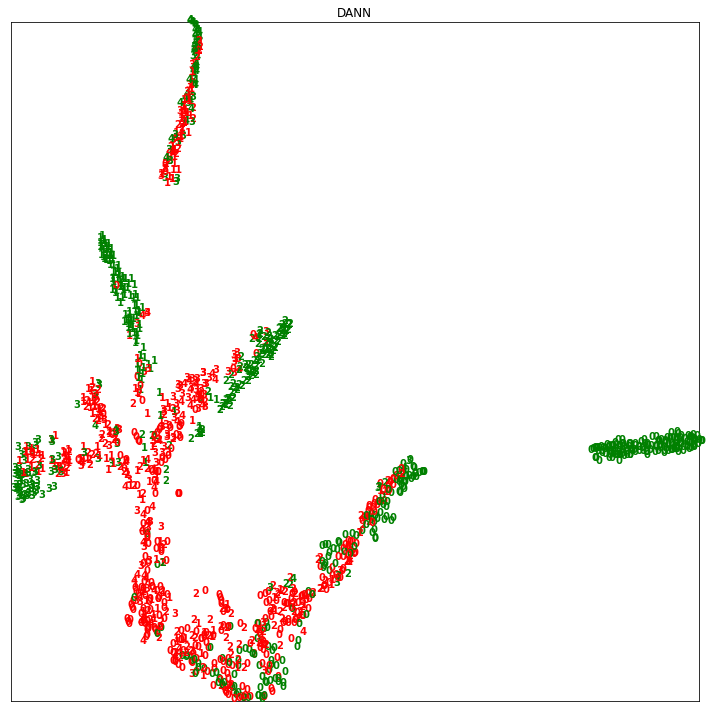

In [ ]:
feature_model = Model(model.input, model.get_layer('feature').output)
emb = feature_model.predict(combined_test_imgs)
tsne = TSNE(perplexity=50, n_components=2, init='pca', n_iter=500)
tsne_model = tsne.fit_transform(emb)
plot_embedding1(tsne_model, combined_test_labels.argmax(1)
               ,combined_test_domain.argmax(1),'DANN')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
100%|██████████| 1436/1436 [00:00<00:00, 2739.60it/s]


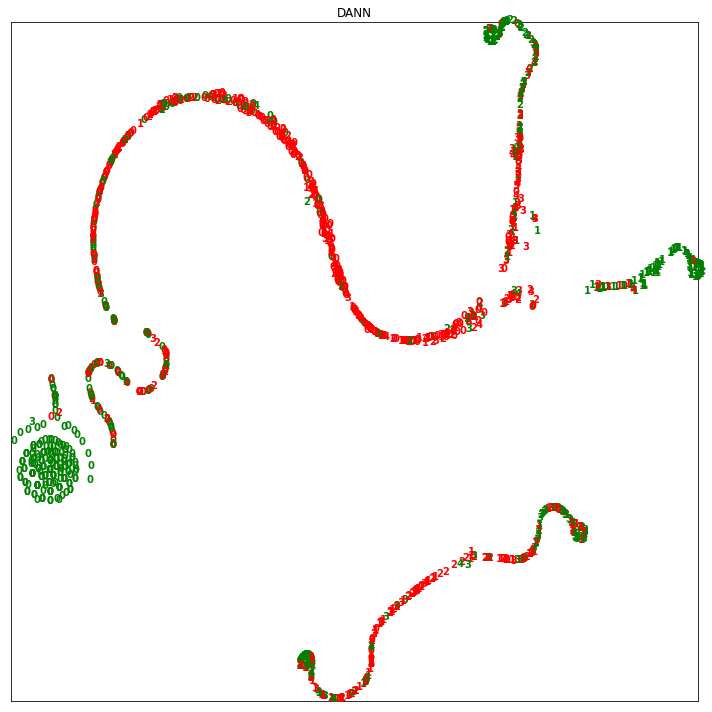

In [ ]:
feature_model = Model(model.input, model.get_layer('classifier_output').output)
emb = feature_model.predict(combined_test_imgs)
tsne = TSNE(perplexity=50, n_components=2, init='pca', n_iter=500)
tsne_model = tsne.fit_transform(emb)
plot_embedding1(tsne_model, combined_test_labels.argmax(1)
               ,combined_test_domain.argmax(1),'DANN')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
100%|██████████| 1436/1436 [00:00<00:00, 4968.00it/s]


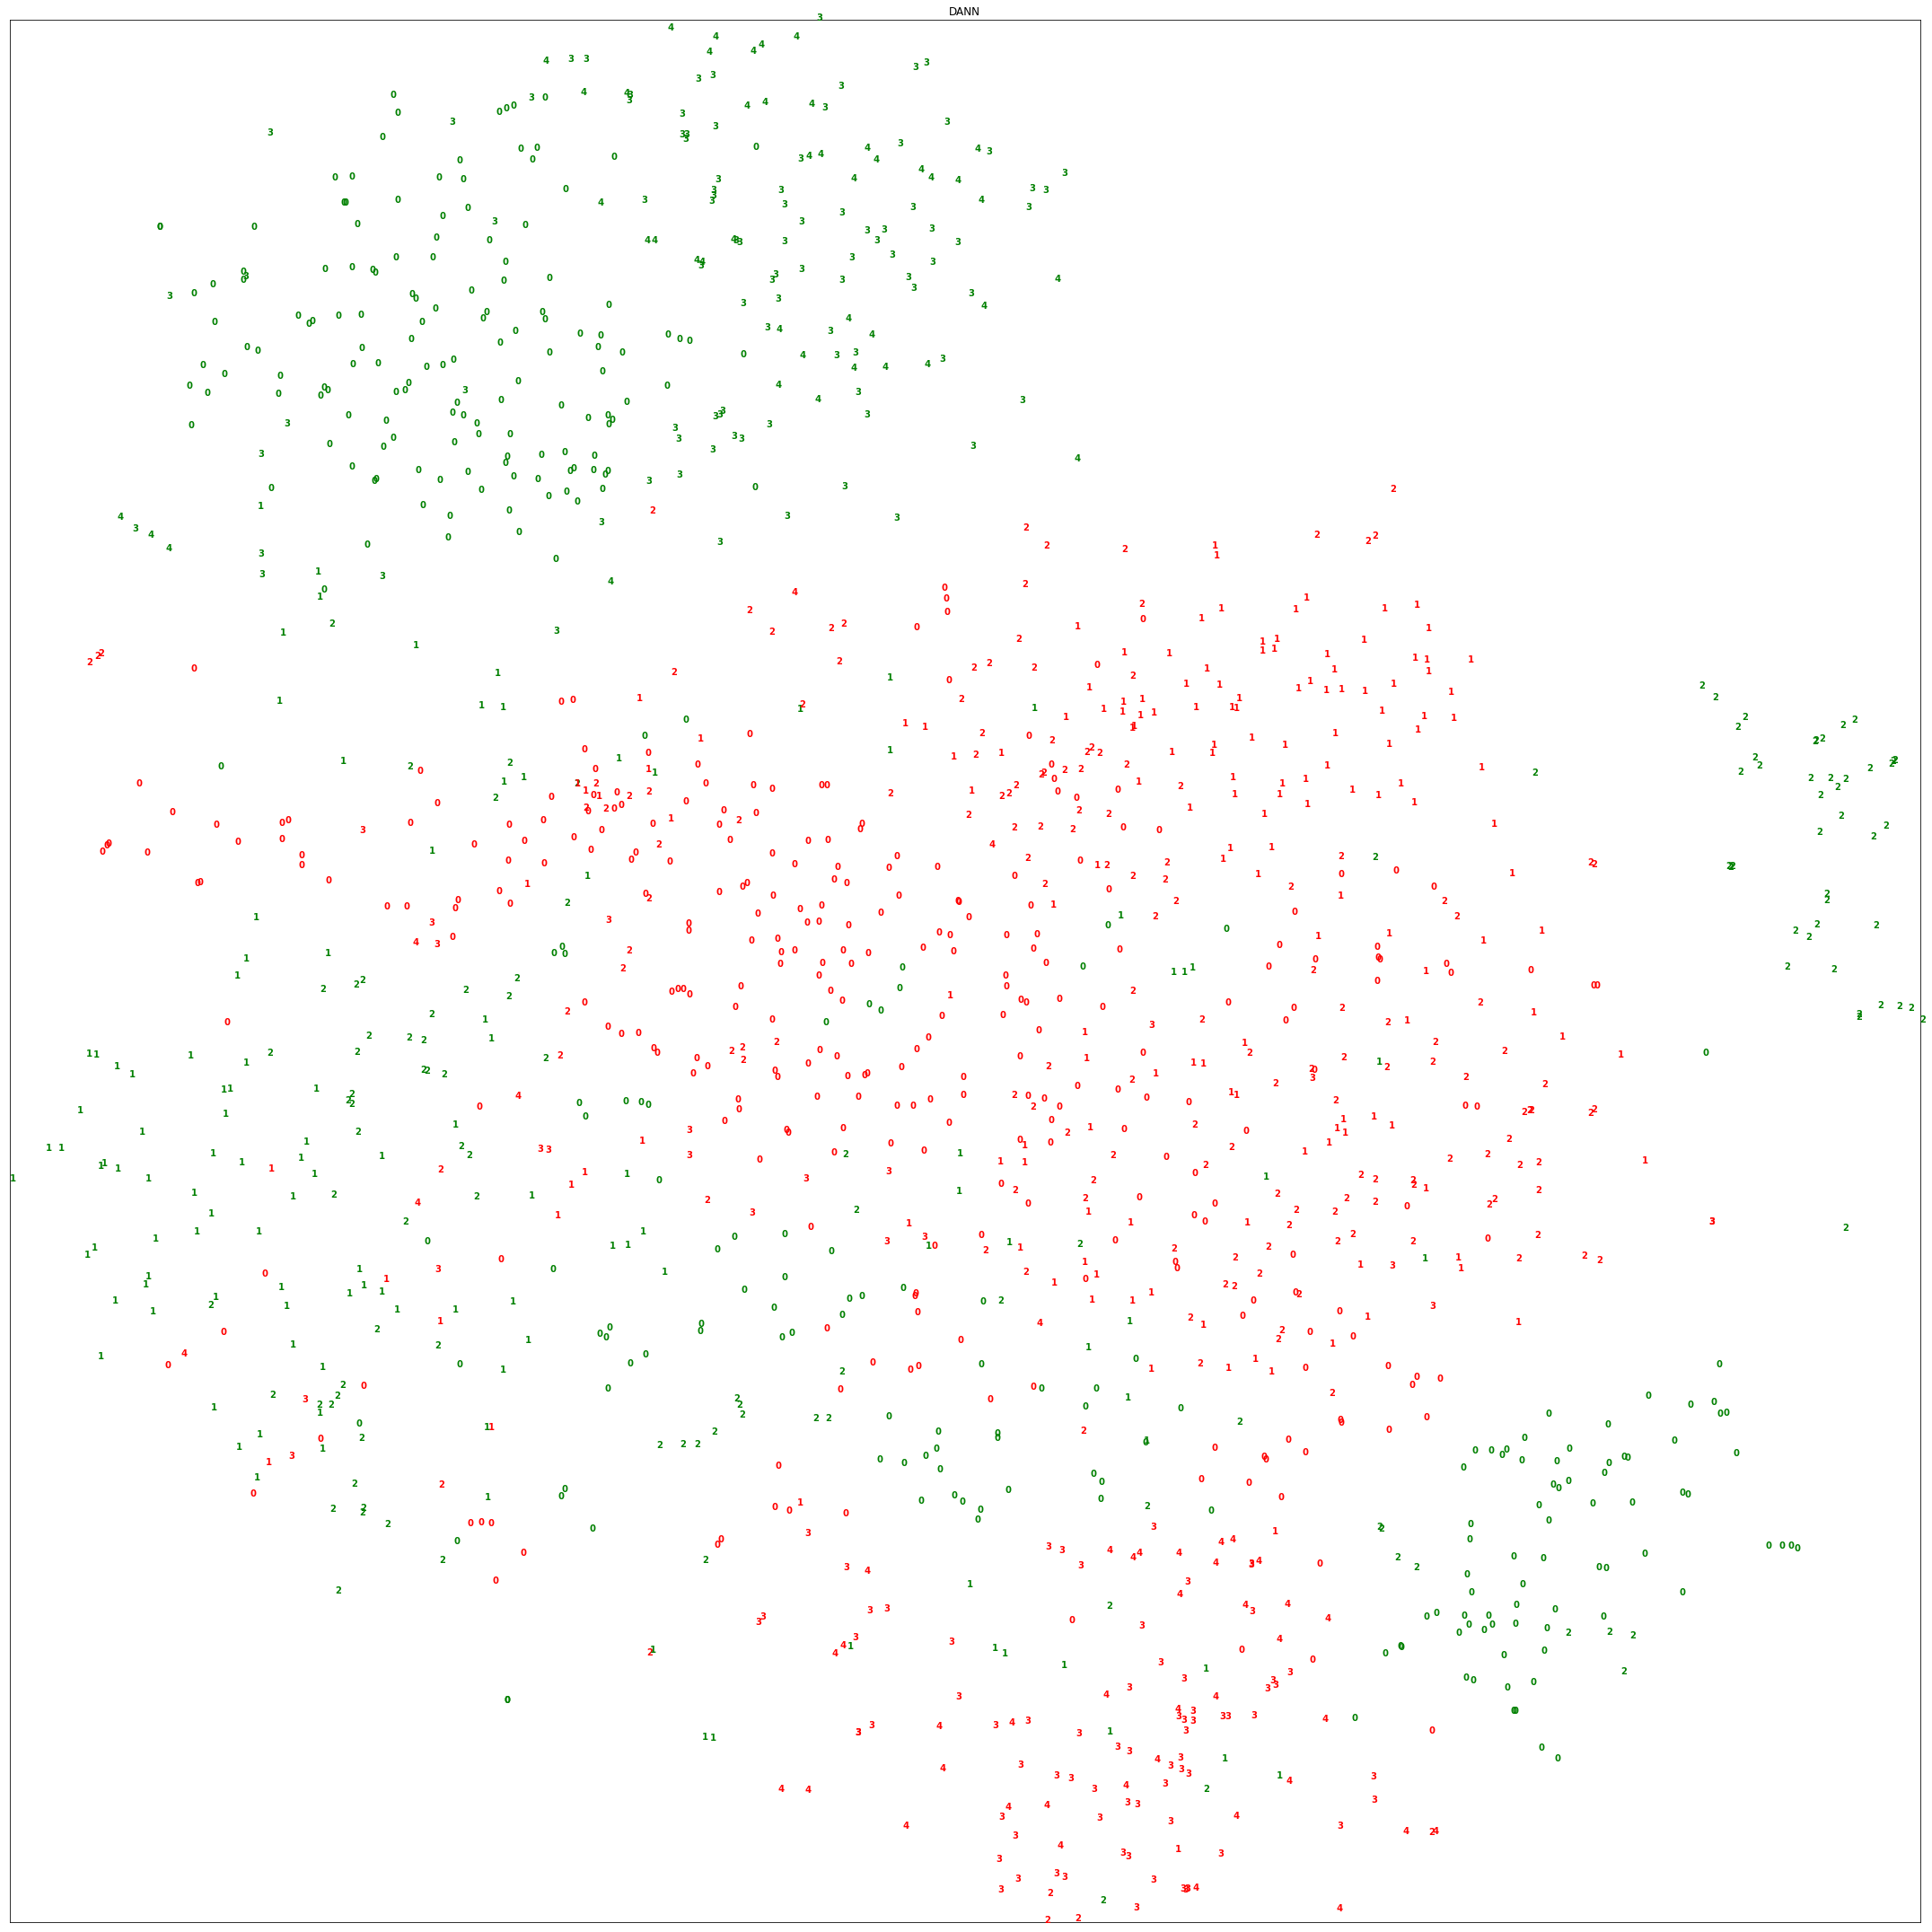

In [ ]:
feature_model = Model(TSNE_model_none.input, TSNE_model_none.get_layer('feature').output)
emb = feature_model.predict(combined_test_imgs)
tsne = TSNE(perplexity=50, n_components=2, init='pca', n_iter=500)
tsne_model = tsne.fit_transform(emb)
plot_embedding2(tsne_model, combined_test_labels.argmax(1)
               ,combined_test_domain.argmax(1),'DANN')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
100%|██████████| 1436/1436 [00:00<00:00, 2453.95it/s]


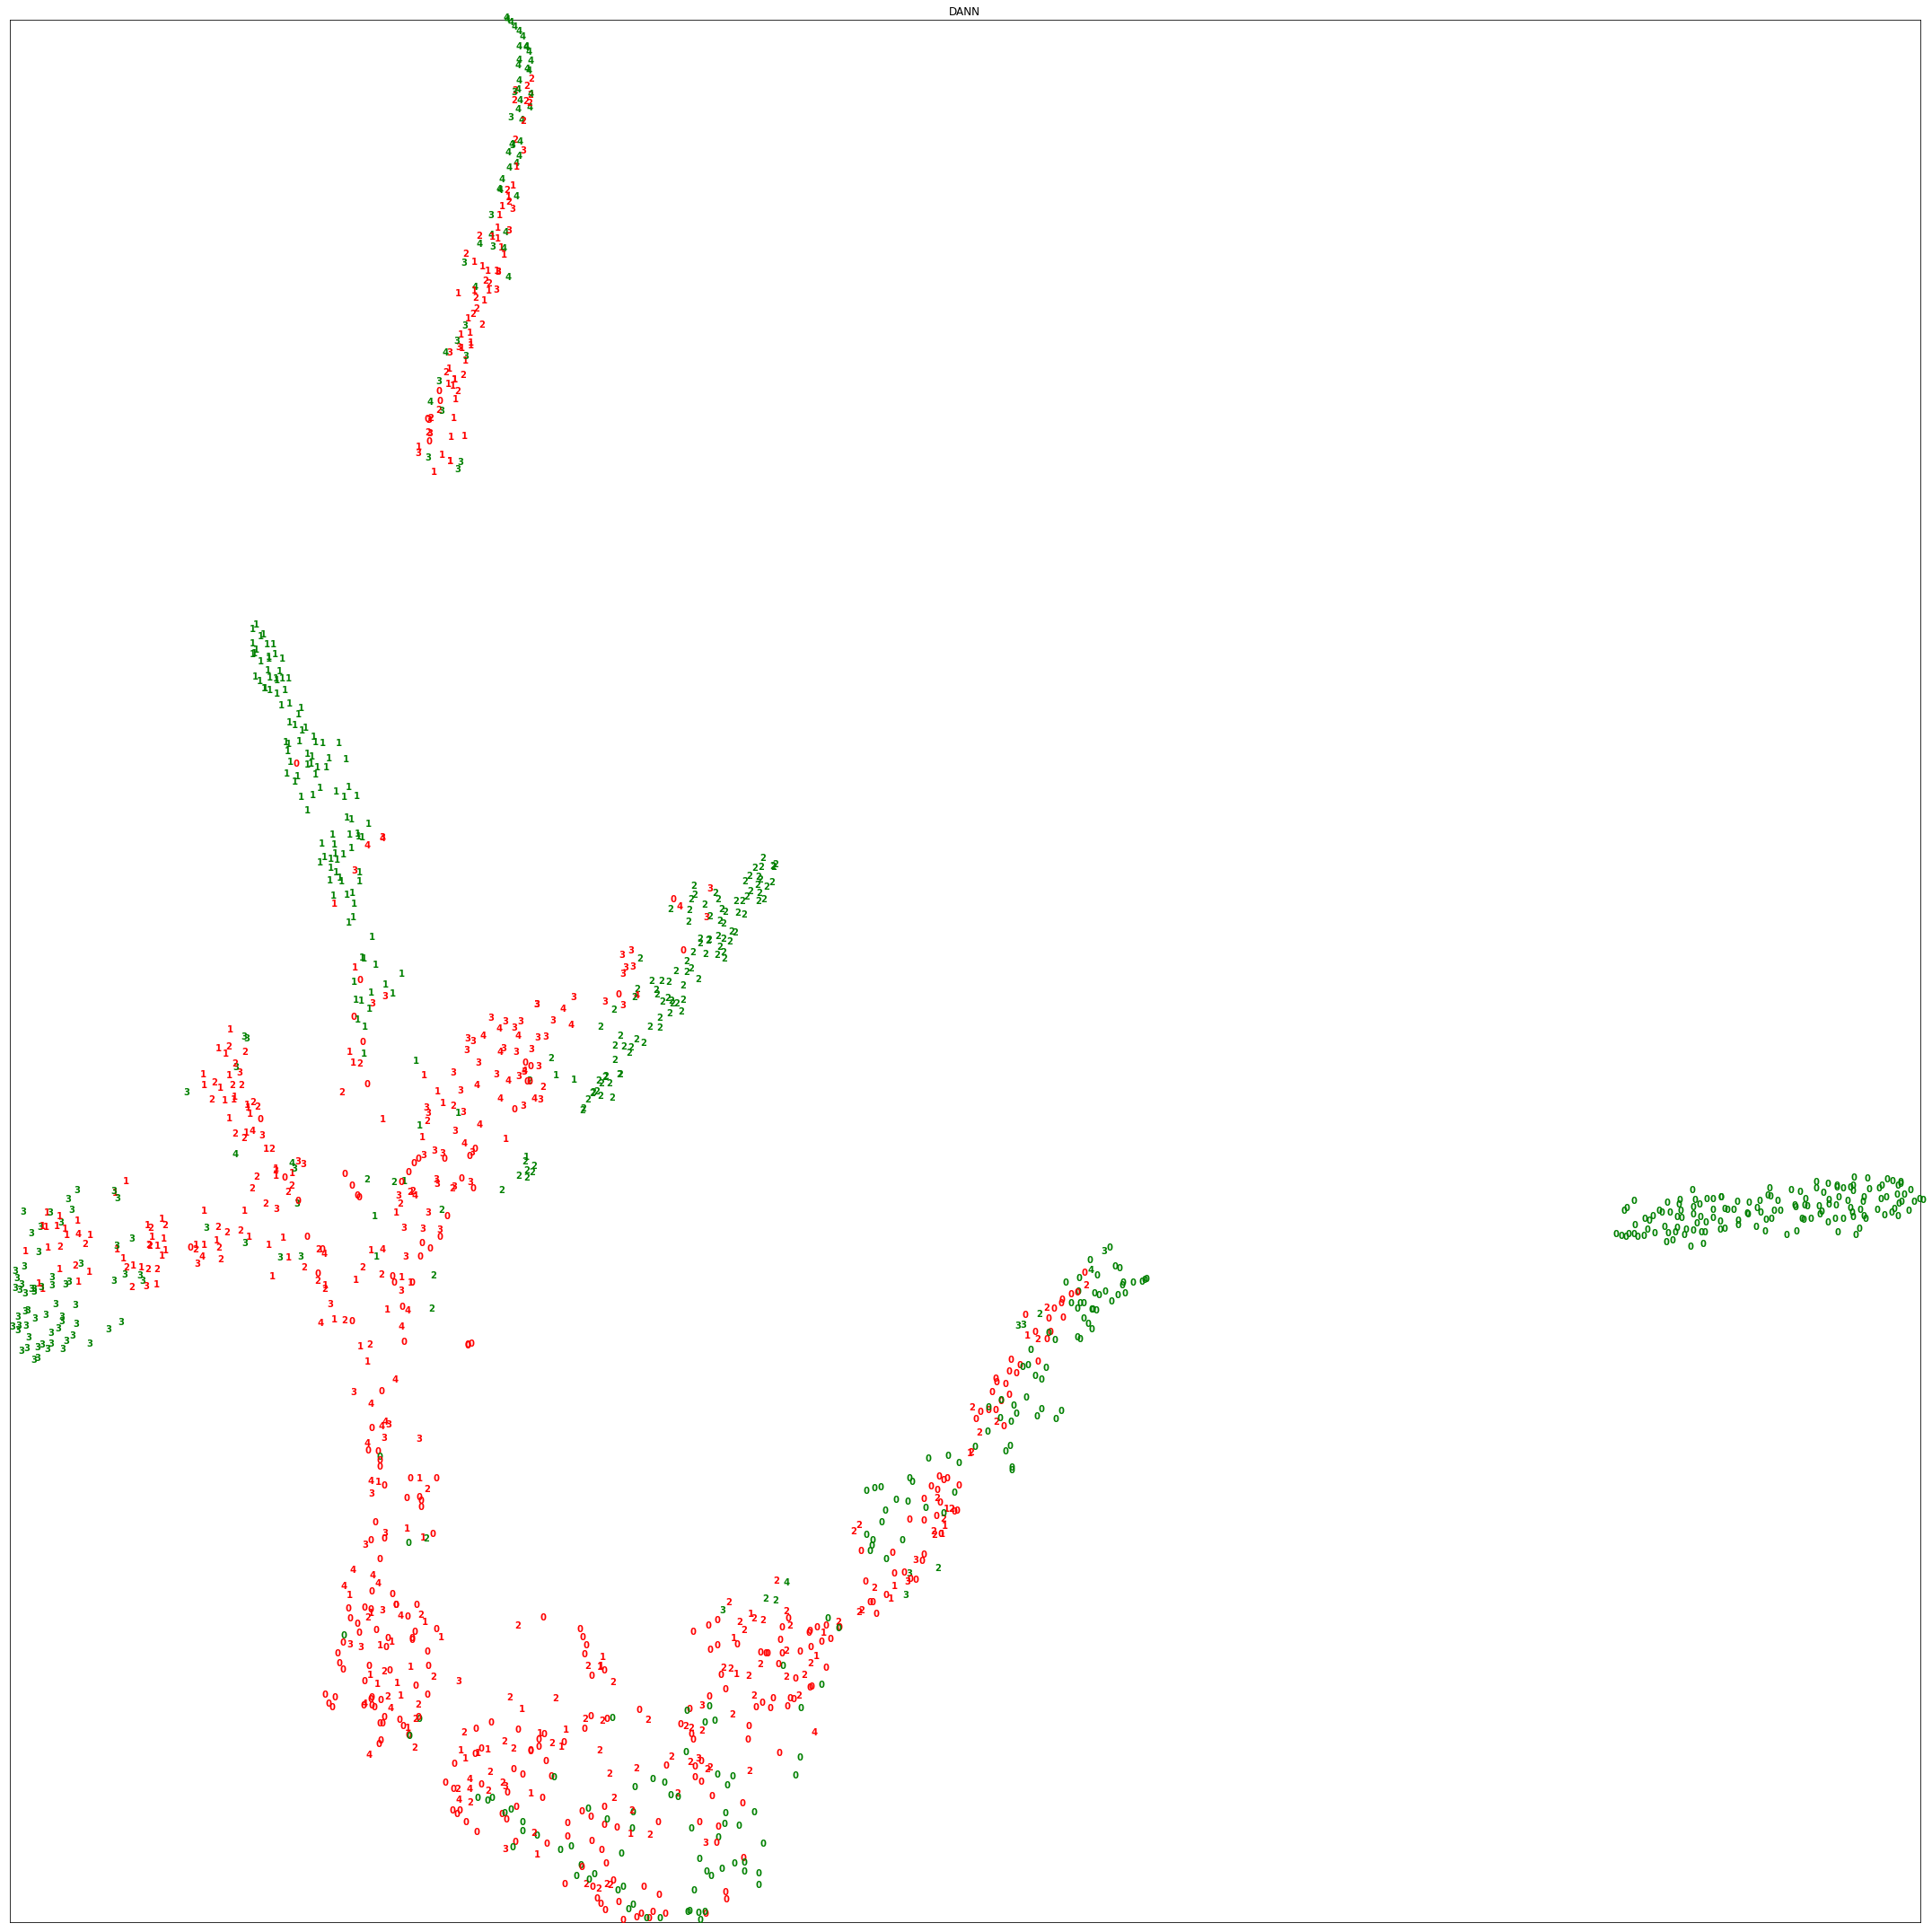

In [ ]:
feature_model = Model(model.input, model.get_layer('feature').output)
emb = feature_model.predict(combined_test_imgs)
tsne = TSNE(perplexity=50, n_components=2, init='pca', n_iter=500)
tsne_model = tsne.fit_transform(emb)
plot_embedding2(tsne_model, combined_test_labels.argmax(1)
               ,combined_test_domain.argmax(1),'DANN')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
100%|██████████| 1436/1436 [00:00<00:00, 2648.17it/s]


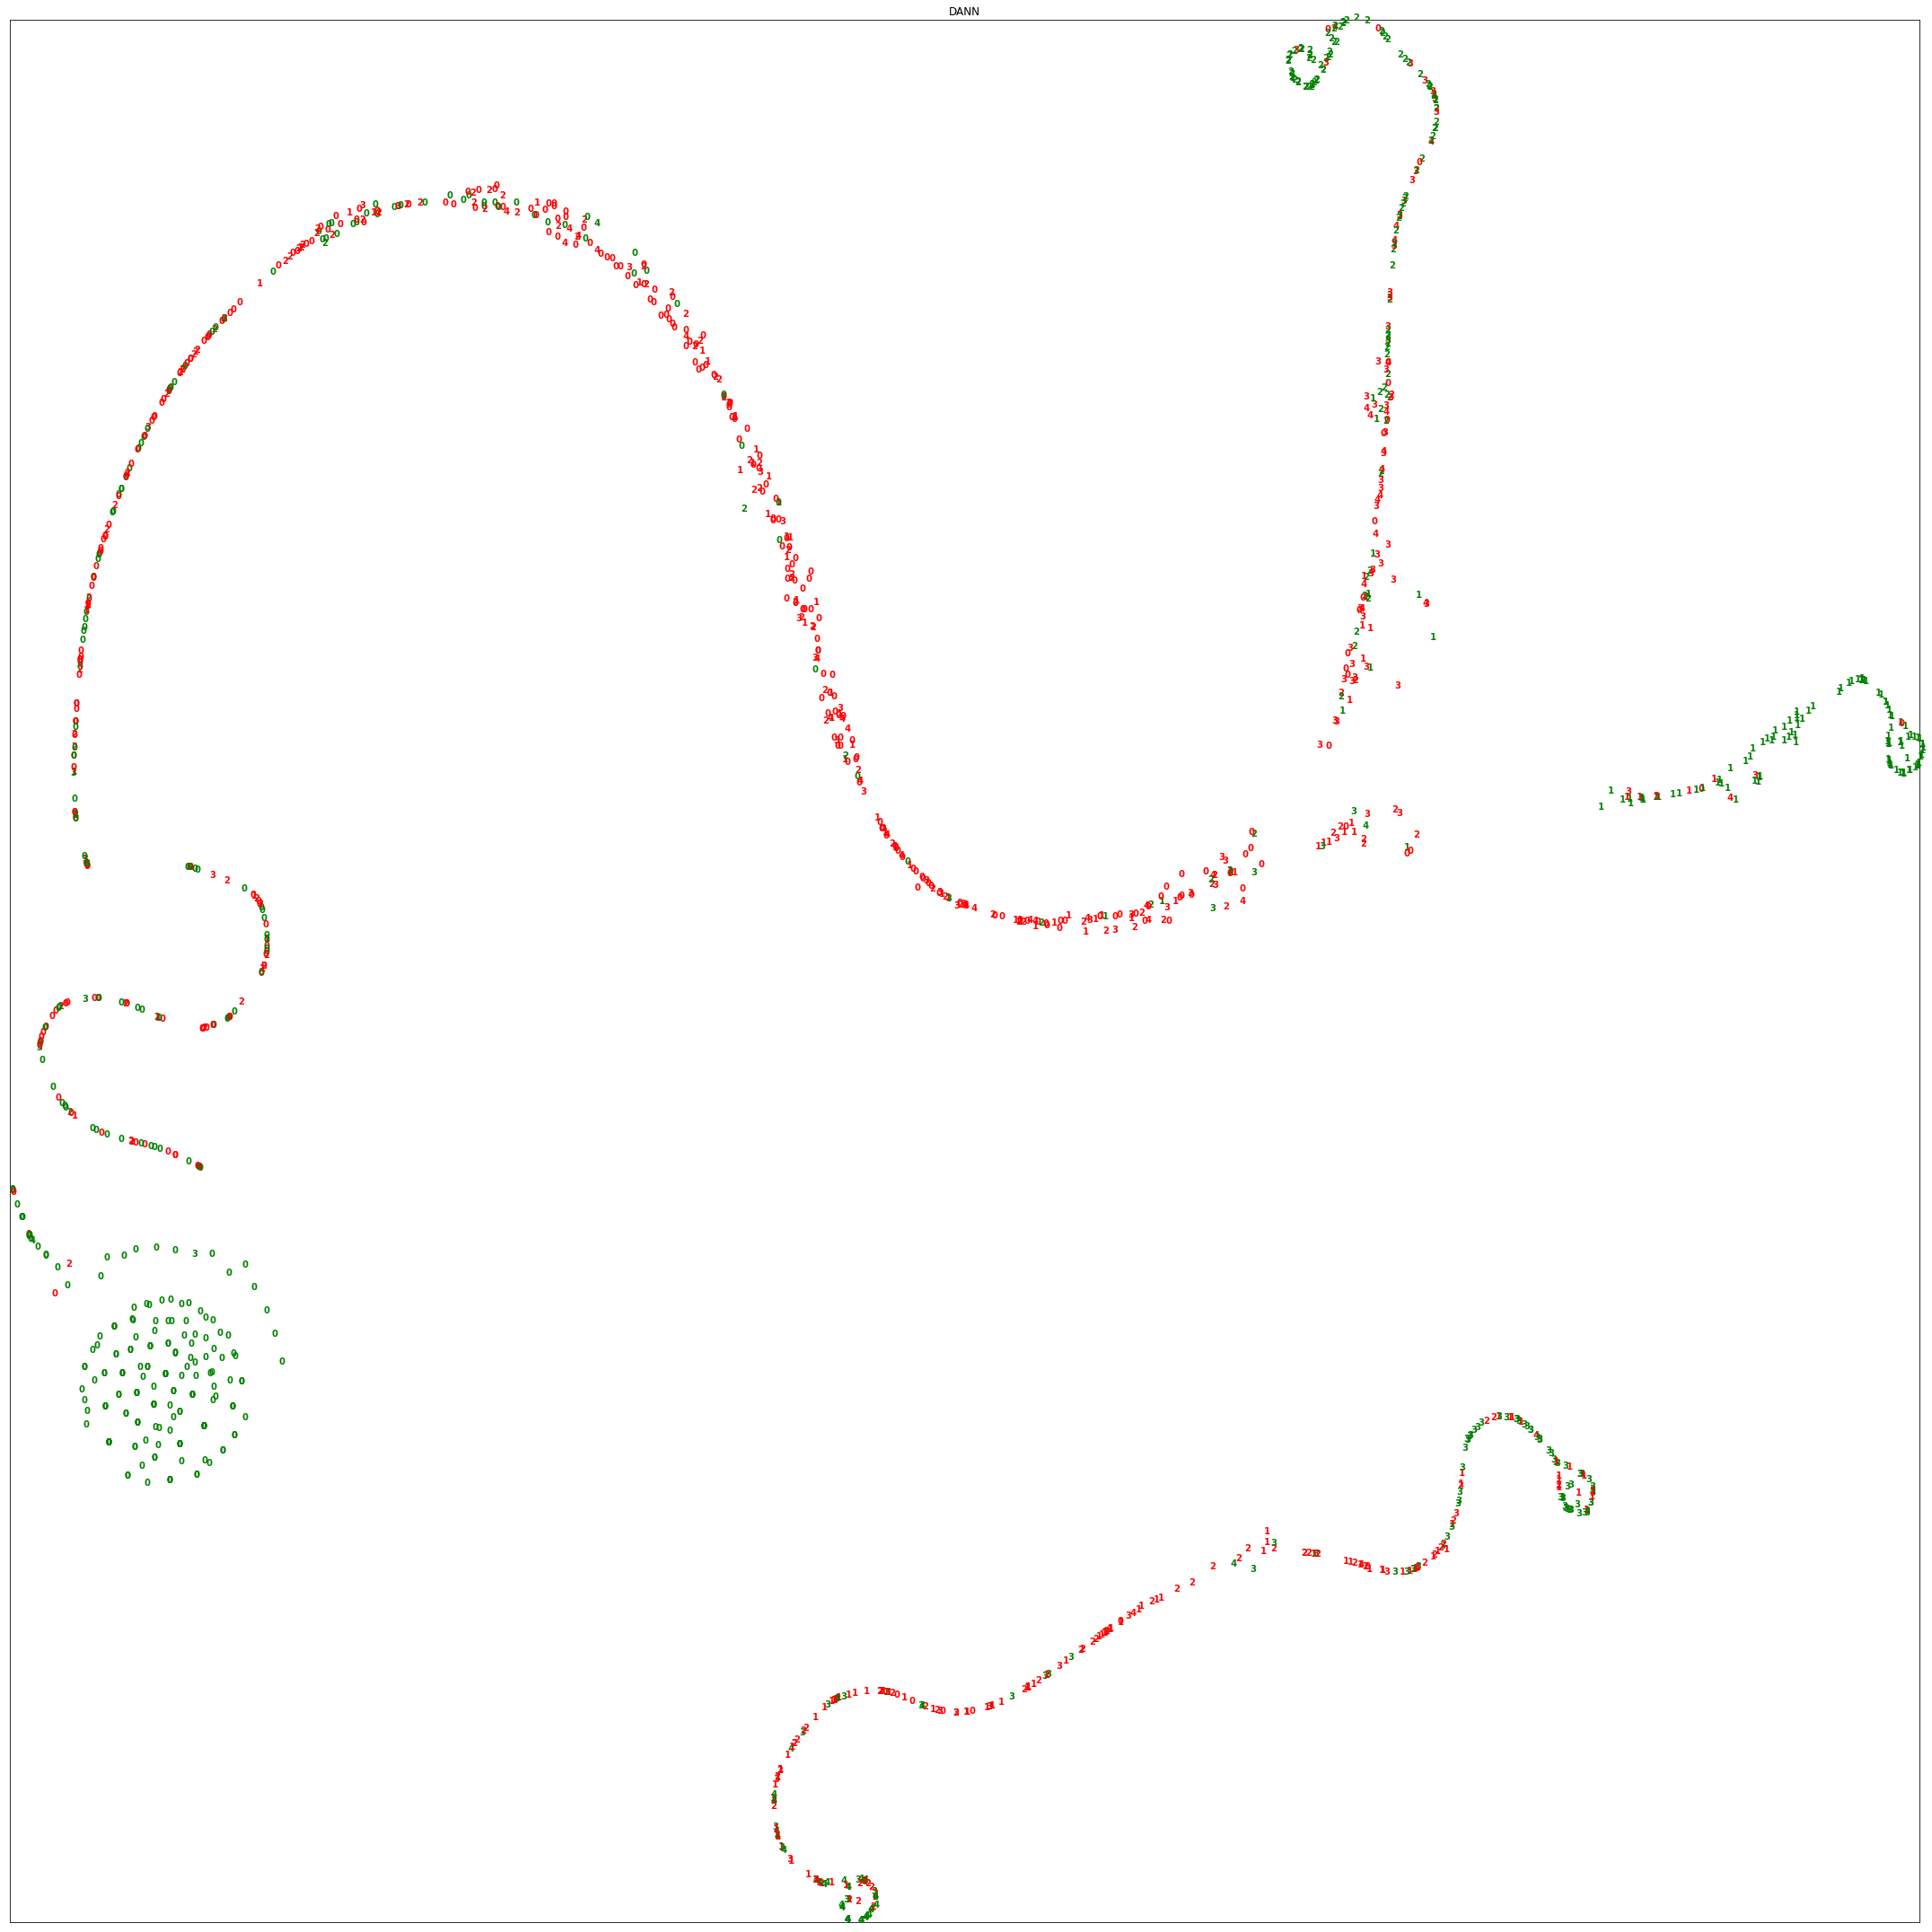

In [ ]:
feature_model = Model(model.input, model.get_layer('classifier_output').output)
emb = feature_model.predict(combined_test_imgs)
tsne = TSNE(perplexity=50, n_components=2, init='pca', n_iter=500)
tsne_model = tsne.fit_transform(emb)
plot_embedding2(tsne_model, combined_test_labels.argmax(1)
               ,combined_test_domain.argmax(1),'DANN')